# Actividad 5 | Actividad de visualización de resultados
---

**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4034.10 - Análisis de grandes volúmenes de datos**

Tecnológico de Monterrey

* Dr. Iván Olmos Pineda
* Mtra. Verónica Sandra Guzmán de Valle
* Mtro. Alberto Daniel Salinas Montemayor

---

**Equipo 37**

|  NOMBRE COMPLETO                        |     MATRÍCULA     |
| :-------------------------------------: |:-----------------:|
| Alejandro Díaz Villagómez               |  A01276769        |
| Alonso Pedrero Martínez                 |  A01769076        |
| César Iván Pedrero Martínez             |  A01366501        |
| Emiliano Saucedo Arriola                |  A01659258        |

In [1]:
import findspark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import StringType, DoubleType, FloatType
import findspark

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import pandas as pd
from os import path

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from functools import reduce
from pyspark.sql import DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

In [2]:
findspark.init()
findspark.find()

'/Users/alonsopedreromartinez/Documents/GitHub/big_data/act 5/act_5_big_data/lib/python3.12/site-packages/pyspark'

In [3]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/22 21:42:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
PATH = "../files"
FILE = "amazon_electronics.csv"

In [5]:
class FileManager():
    @staticmethod
    def open_csv_file(input_path : str, file_name : str):
        """
        This method opens a csv file with pyspark
        """
        csv_df = spark.read.csv(
            path.join(input_path, file_name),
            header=True,
            inferSchema=True,
            multiLine=True,
            escape="\"",
            quote="\""
        )

        csv_df.show(truncate=20)

        return csv_df

In [6]:
df_reviews = FileManager.open_csv_file(PATH, FILE)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|sentiment|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------+
|         US|   22873041|R3ARRMDEGED8RD|B00KJWQIIC|     335625766|Plemo 14-Inch Lap...|              PC|          5|            0|          0|   N|                Y|Pleasantly surprised|I was very surpri...| 2015-08-31|        1|
|         US|   30088427| RQ28TSA020Y6J|B013ALA9LA|     671157305|TP-Link OnHub 

In [7]:
# Previously defined relevant columns for the activity.
RELEVANT_COLUMNS_FOR_CHARACTERIZATION = [
  "star_rating",
  "helpful_votes",
  "total_votes",
  "vine",
  "verified_purchase",
  "review_date",
  "sentiment"
]

In [8]:
df_reviews_filtered = df_reviews.select(*RELEVANT_COLUMNS_FOR_CHARACTERIZATION)

In [9]:
class PartitioningManager:

    @staticmethod
    def compute_probabilities(df, cols):
        """
        Computes and returns the probability of each combination of values in the specified columns.
        """
        total_count = df.count()
        return df.groupBy(cols).count() \
                 .withColumn("probability", F.round(F.col("count") / total_count, 6)) \
                 .orderBy("probability", ascending=False)

    @staticmethod
    def filter_partition(df, star_rating, verified_purchase, vine):
        """
        Filters the DataFrame by specific values for rating, verified purchase, and vine.
        """
        return df.filter(
            (F.col("star_rating") == star_rating) &
            (F.col("verified_purchase") == verified_purchase) &
            (F.col("vine") == vine)
        )

    @staticmethod
    def generate_all_partitions(df, min_probability=0.0001):
        """
        Generates partitions only for combinations whose joint probability is above min_probability.
        """

        prob_df = PartitioningManager.compute_probabilities(
            df, ["star_rating", "verified_purchase", "vine"]
        )

        filtered_combinations = prob_df.filter(
            F.col("probability") >= min_probability
        ).select("star_rating", "verified_purchase", "vine").collect()

        partitions = {}
        for row in filtered_combinations:
            rating = row["star_rating"]
            purchase = row["verified_purchase"]
            vine = row["vine"]

            key = f"R{rating}_VP{purchase}_V{vine}"
            filtered = PartitioningManager.filter_partition(df, rating, purchase, vine)
            partitions[key] = filtered
            print(f"Partition {key} created with {filtered.count()} records.")

        return partitions

    @staticmethod
    def stratified_sample_partitioned_data(partitions_dict, label_col="sentiment", fraction=0.3, min_rows=50):
        """
        Applies stratified sampling to each partition based on sentiment.
        """
        sampled_partitions = {}

        for key, df in partitions_dict.items():
            count = df.count()

            if count < min_rows:
                print(f"Skipping partition {key} — only {count} rows (<{min_rows})")
                continue

            sentiments = df.select(label_col).distinct().rdd.flatMap(lambda x: x).collect()
            fractions = {s: fraction for s in sentiments}

            sampled_df = df.sampleBy(label_col, fractions, seed=42)
            sampled_partitions[key] = sampled_df
            print(f"Sampled {sampled_df.count()} rows from partition {key} (original: {count})")

        return sampled_partitions

    @staticmethod
    def build_combined_sample(partitions_sampled_dict):
        """
        Unites all sampled partitions into a single DataFrame (M).
        This helps reduce computational load while maintaining diversity.
        """
        if not partitions_sampled_dict:
            raise ValueError("No partitions provided for sample combination.")

        combined_df = None
        for key, df in partitions_sampled_dict.items():
            if combined_df is None:
                combined_df = df
            else:
                combined_df = combined_df.union(df)
            print(f"Partition {key} added to the combined sample.")

        print(f"Total records in combined sample: {combined_df.count()}")
        return combined_df


In [10]:
partitions = PartitioningManager.generate_all_partitions(df_reviews, min_probability=0.001)

Partition R5_VPY_VN created with 3679909 records.


Partition R4_VPY_VN created with 1019728 records.


Partition R1_VPY_VN created with 603371 records.


Partition R3_VPY_VN created with 443364 records.


Partition R5_VPN_VN created with 410073 records.


Partition R2_VPY_VN created with 300544 records.


Partition R1_VPN_VN created with 152779 records.


Partition R4_VPN_VN created with 135197 records.


Partition R3_VPN_VN created with 65398 records.


Partition R2_VPN_VN created with 59973 records.


Partition R5_VPN_VY created with 15604 records.


Partition R4_VPN_VY created with 13240 records.


In [11]:
# Sample of one of the generated partitions.
partitions["R4_VPY_VN"].show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|sentiment|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------+
|         US|   49329488|R1QF6RS1PDLU18|B00TR05L9Y|     778403103|Lenovo TAB2 A10 -...|              PC|          4|            1|          1|   N|                Y|                Good|I am not sure I d...| 2015-08-31|        1|
|         US|   43341796|R2NJ3WFUS4E5G6|B00YGJJQ6U|     986548413|Fintie iPad Ai

In [12]:
sampled_partitions = PartitioningManager.stratified_sample_partitioned_data(partitions, fraction=0.01, min_rows=100)

Sampled 37034 rows from partition R5_VPY_VN (original: 3679909)


Sampled 10354 rows from partition R4_VPY_VN (original: 1019728)


Sampled 6065 rows from partition R1_VPY_VN (original: 603371)


Sampled 4437 rows from partition R3_VPY_VN (original: 443364)


Sampled 4077 rows from partition R5_VPN_VN (original: 410073)


Sampled 2974 rows from partition R2_VPY_VN (original: 300544)


Sampled 1537 rows from partition R1_VPN_VN (original: 152779)


Sampled 1345 rows from partition R4_VPN_VN (original: 135197)


Sampled 710 rows from partition R3_VPN_VN (original: 65398)


Sampled 647 rows from partition R2_VPN_VN (original: 59973)


Sampled 173 rows from partition R5_VPN_VY (original: 15604)


Sampled 150 rows from partition R4_VPN_VY (original: 13240)


In [13]:
df_sample_M = PartitioningManager.build_combined_sample(sampled_partitions)

Partition R5_VPY_VN added to the combined sample.
Partition R4_VPY_VN added to the combined sample.
Partition R1_VPY_VN added to the combined sample.
Partition R3_VPY_VN added to the combined sample.
Partition R5_VPN_VN added to the combined sample.
Partition R2_VPY_VN added to the combined sample.
Partition R1_VPN_VN added to the combined sample.
Partition R4_VPN_VN added to the combined sample.
Partition R3_VPN_VN added to the combined sample.
Partition R2_VPN_VN added to the combined sample.
Partition R5_VPN_VY added to the combined sample.
Partition R4_VPN_VY added to the combined sample.


Total records in combined sample: 69503


In [14]:
class StatisticalAnalysisHelper():
    @staticmethod
    def dataset_dimensions(df_input):
        print("columns in the dataset:", len(df_input.columns))
        print("rows in the dataset:", df_input.count())

    @staticmethod
    def schema_information(df_input):
        """
        This method shows the current schema of the data.
        """
        df_input.printSchema()

    @staticmethod
    def descriptive_statistics(df_input):
        """
        This method shows the descriptive statistics of the data.
        """
        df_input.summary().show(truncate=False)

    @staticmethod
    def missing_values_table(df_input):
        """
        Displays a table with the count of missing values per column.
        """
        missing_exprs = []
        
        for c in df_input.schema.fields:
            field_name = c.name
            field_type = c.dataType
            
            if isinstance(field_type, (DoubleType, FloatType)):
                missing_exprs.append(
                    count(when(col(field_name).isNull() | isnan(col(field_name)), field_name)).alias(field_name)
                )
            elif isinstance(field_type, StringType):
                missing_exprs.append(
                    count(when(col(field_name).isNull() | (col(field_name) == ""), field_name)).alias(field_name)
                )
            else:
                missing_exprs.append(
                    count(when(col(field_name).isNull(), field_name)).alias(field_name)
                )

        df_missing_values = df_input.select(missing_exprs)

        return df_missing_values

In [15]:
StatisticalAnalysisHelper.dataset_dimensions(df_sample_M)

columns in the dataset: 16


rows in the dataset: 69503


In [16]:
StatisticalAnalysisHelper.schema_information(df_sample_M)

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- sentiment: integer (nullable = true)



In [17]:
StatisticalAnalysisHelper.descriptive_statistics(df_sample_M)

25/06/22 21:50:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------+--------------------+--------------+-------------------+--------------------+----------------------------------------------------------------------------------------------+----------------+------------------+------------------+------------------+-----+-----------------+---------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|summary|marketplace|customer_id         |review_id     |product_id         |product_parent      |product_title                      

In [18]:
missing_values = StatisticalAnalysisHelper.missing_values_table(df_sample_M)
missing_values.show(truncate=False)

+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+---------+
|marketplace|customer_id|review_id|product_id|product_parent|product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline|review_body|review_date|sentiment|
+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+---------+
|0          |0          |0        |0         |0             |0            |0               |0          |0            |0          |0   |0                |0              |0          |0          |0        |
+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+---

In [19]:
class TrainTestManager:
  @staticmethod
  def stratified_train_test_split(df, label_col, train_ratio : int, seed : int):
    """
    Performs a stratified split of the DataFrame based on the label column.
    Returns (train_df, test_df).
    """
    label_values = df.select(label_col).distinct().rdd.flatMap(lambda x: x).collect()

    train_fractions = {label: train_ratio for label in label_values}

    train_df = df.sampleBy(label_col, train_fractions, seed=seed)

    train_ids = train_df.select(F.monotonically_increasing_id().alias("id"))
    df_with_id = df.withColumn("id", F.monotonically_increasing_id())

    test_df = df_with_id.join(train_ids, on="id", how="left_anti").drop("id")
    train_df = train_df.drop("id") if "id" in train_df.columns else train_df

    print(f"Train set: {train_df.count()} rows")
    print(f"Test set: {test_df.count()} rows")

    return train_df, test_df

In [20]:
class ManualLogisticRegressionManager:
    
    @staticmethod
    def evaluate_binary_classification(predictions, label_col: str = "label", prediction_col: str = "prediction", probability_col: str = "probability"):
        """
        Evalúa un modelo de clasificación binaria en base a varias métricas estándar.
        """
        accuracy = predictions.filter(F.col(label_col) == F.col(prediction_col)).count() / predictions.count()
        
        tp = predictions.filter((F.col(prediction_col) == 1) & (F.col(label_col) == 1)).count()
        fp = predictions.filter((F.col(prediction_col) == 1) & (F.col(label_col) == 0)).count()
        fn = predictions.filter((F.col(prediction_col) == 0) & (F.col(label_col) == 1)).count()
        
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

        evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol=probability_col, metricName="areaUnderROC")
        auc = evaluator.evaluate(predictions)

        results_df = pd.DataFrame({
            "accuracy": [accuracy],
            "precision": [precision],
            "recall": [recall],
            "f1_score": [f1],
            "auc": [auc]
        })

        return results_df
    
    @staticmethod
    def preprocess_data(df_train, df_test, feature_cols, label_col="sentiment"):
        """
        Arma un pipeline para ensamblar y escalar características.
        """
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
        scaler = StandardScaler(inputCol="features_vec", outputCol="features", withStd=True, withMean=False)
        pipeline = Pipeline(stages=[assembler, scaler])

        pipeline_model = pipeline.fit(df_train)
        train_preprocessed = pipeline_model.transform(df_train)
        test_preprocessed = pipeline_model.transform(df_test)

        return train_preprocessed, test_preprocessed

    @staticmethod
    def train_logistic_regression(train_df, test_df, label_col="sentiment"):
        """
        Trains a logistic regression model on the training set and evaluates it on the test set.
        Returns the trained model and evaluation metrics.
        """
        lr = LogisticRegression(labelCol=label_col, featuresCol="features", maxIter=10)

        paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.1])
            .addGrid(lr.elasticNetParam, [0.0])
            .build())

        evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol="rawPrediction", metricName="areaUnderROC")

        cv = CrossValidator(estimator=lr,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            numFolds=2,
                            parallelism=2)

        cv_model = cv.fit(train_df)
        best_model = cv_model.bestModel

        predictions = best_model.transform(test_df)

        print(f"BEst model: RegParam = {best_model._java_obj.getRegParam()}, ElasticNet = {best_model._java_obj.getElasticNetParam()}")
        
        return predictions, best_model

    @staticmethod
    def plot_roc_curve(predictions, label_col="sentiment", probability_col="probability"):
        """
        Grafica la curva ROC a partir de un DataFrame de predicciones de PySpark.
        """
        # Convertir a Pandas
        preds_pd = predictions.select(probability_col, label_col).toPandas()
        
        # Extraer probabilidad de clase positiva (1)
        preds_pd["prob_1"] = preds_pd[probability_col].apply(lambda x: float(x[1]))
        
        fpr, tpr, _ = roc_curve(preds_pd[label_col], preds_pd["prob_1"])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC)")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_confusion_matrix(predictions, label_col="label", prediction_col="prediction"):
        """
        Muestra la matriz de confusión usando sklearn.
        """
        preds_pd = predictions.select(prediction_col, label_col).toPandas()
        cm = confusion_matrix(preds_pd[label_col], preds_pd[prediction_col])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.grid(False)
        plt.show()

### 📍**1. Validación cruzada - Elección de `k` y justificación**

Aquí va tanto la explicación como la implementación inicial. Este es el texto sugerido (puedes copiarlo directamente como markdown en tu notebook):

---

#### 📌 Sección 1: Validación Cruzada - Elección de `k`

Para garantizar que los resultados obtenidos por nuestro modelo sean representativos y generalizables, implementaremos un proceso de validación cruzada **estratificada**. Esta técnica nos permitirá medir la **variabilidad del desempeño** del modelo cuando se entrena y evalúa en diferentes subconjuntos de la muestra.

##### 📋 ¿Por qué usar validación cruzada?

* Permite estimar el rendimiento del modelo de manera más robusta.
* Es especialmente útil cuando se tienen conjuntos de datos limitados o cuando se busca minimizar el sobreajuste.
* En nuestro caso, dado que ya trabajamos con una muestra balanceada y estratificada (`M`), es importante asegurar que cada fold mantenga la misma proporción de clases (`sentiment`) para una evaluación justa.

##### 🔢 Elección de `k`

Seleccionamos un valor de `k=5` por las siguientes razones:

* Es un valor comúnmente usado que ofrece un buen equilibrio entre **varianza del estimador** y **costo computacional**.
* Dado el tamaño reducido de la muestra `M` (obtenida por muestreo estratificado desde la población original), `k=5` nos permite mantener un número suficiente de observaciones en cada fold para que el entrenamiento sea válido.
* Evitamos valores muy grandes de `k` ya que la ejecución en PySpark es más costosa computacionalmente.

---

¿Quieres que continuemos ya con el **código de implementación del paso 2 (construcción de los folds k=5)** o quieres revisar/redactar tú mismo esta parte antes de seguir?

Puedo ayudarte directamente con el código para construir los folds de validación cruzada usando PySpark y tu muestra `df_sample_M`.


### Sección 2: Construcción de los k-folds

El objetivo aquí es:

Dividir la muestra df_sample_M en k subconjuntos estratificados según la variable sentiment.
Asegurar que en cada fold haya una proporción representativa de clases.
Guardar los k folds para luego entrenar con combinaciones (k-1 para entrenamiento y 1 para prueba).

In [21]:
def manual_group_kfold(df_spark, group_col, n_splits=5):
    """
    Divide un DataFrame de Spark en folds sin mezclar grupos.
    """
    unique_groups = df_spark.select(group_col).distinct().toPandas()[group_col].sample(frac=1).tolist()  # shuffle
    group_folds = [unique_groups[i::n_splits] for i in range(n_splits)]
    
    folds = []
    for i in range(n_splits):
        val_groups = group_folds[i]
        train_groups = [g for j, fold in enumerate(group_folds) if j != i for g in fold]

        train_df = df_spark.filter(col(group_col).isin(train_groups))
        val_df = df_spark.filter(col(group_col).isin(val_groups))
        
        folds.append((train_df, val_df))
    
    return folds

In [22]:
from pyspark.sql import DataFrame
import random

class CrossValidationManager:
    @staticmethod

    
    def stratified_k_fold_split(df: DataFrame, label_col: str, k: int, seed: int = 42):
        """
        Divide un DataFrame en k folds estratificados con base en la columna de etiqueta.
        Devuelve una lista de DataFrames, uno por fold.
        """
        random.seed(seed)
        label_values = df.select(label_col).distinct().rdd.flatMap(lambda x: x).collect()
        
        folds = [[] for _ in range(k)]

        for label in label_values:
            df_label = df.filter(F.col(label_col) == label)
            indexed = df_label.withColumn("rand", F.rand(seed))
            sorted_df = indexed.orderBy("rand")
            total = sorted_df.count()
            size_per_fold = total // k
            remainder = total % k

            start = 0
            for i in range(k):
                end = start + size_per_fold + (1 if i < remainder else 0)
                fold_slice = sorted_df.limit(end).subtract(sorted_df.limit(start))
                folds[i].append(fold_slice)
                start = end

        # Unir cada fold en un solo DataFrame
        folds_df = [folds[i][0].unionAll(folds[i][1]) if len(folds[i]) > 1 else folds[i][0] for i in range(k)]
        
        for i, f in enumerate(folds_df):
            print(f"Fold {i + 1}: {f.count()} registros")

        return folds_df
    
    @staticmethod
    def folds_test_train_set(k_folds_input, n_fold_input : int):
        test_df = k_folds_input[n_fold_input]
        train_df = reduce(DataFrame.union, [k_folds_input[i] for i in range(len(k_folds_input)) if i != n_fold_input])

        test_df = test_df.cache()
        train_df = train_df.cache()

        test_df.count()
        train_df.count()


        return test_df, train_df


In [23]:
k_folds = CrossValidationManager.stratified_k_fold_split(df_sample_M, label_col="sentiment", k=4, seed=42)

Fold 1: 17377 registros


Fold 2: 17376 registros


Fold 3: 17375 registros


Fold 4: 17375 registros


### 3.Entrenamiento del Modelo y Evaluación Exhaustiva
Para evaluar de forma robusta el desempeño del modelo, se implementó un esquema de validación cruzada estratificada con 5 folds utilizando PySpark. Este procedimiento permite dividir el conjunto de datos en cinco subconjuntos de forma que la proporción de clases (variable sentiment) se mantenga equilibrada en cada partición. En cada iteración, uno de los folds se utiliza como conjunto de prueba y los otros cuatro como conjunto de entrenamiento, rotando este esquema hasta completar las cinco combinaciones posibles.

Durante cada iteración se utilizó el método folds_test_train_set, que permite obtener los datos de prueba y entrenamiento correspondientes al fold actual. Para acelerar la experimentación inicial, se aplicó un muestreo aleatorio del 0.1% (fraction=0.001) tanto al conjunto de entrenamiento como al de prueba. Esto se hizo con la finalidad de reducir el tiempo de cómputo sin comprometer la estructura del pipeline.

Se seleccionaron como variables predictoras las siguientes características numéricas: star_rating, helpful_votes y total_votes.

El preprocesamiento de los datos consistió en la construcción de un pipeline con dos etapas: ensamblado de características mediante VectorAssembler y estandarización con StandardScaler. Este proceso se aplicó tanto al conjunto de entrenamiento como al de prueba en cada fold, asegurando una transformación consistente.

Luego del preprocesamiento, se entrenó un modelo de regresión logística con una búsqueda de hiperparámetros limitada utilizando CrossValidator. A pesar de que se empleó una grilla simple en esta etapa, el procedimiento está diseñado para escalar a búsquedas más complejas si se requiere.

Cada modelo entrenado fue evaluado con base en cinco métricas estándar de clasificación binaria:

Accuracy
Precision
Recall
F1-score
Área bajo la curva ROC (AUC)
Las predicciones generadas por el modelo fueron evaluadas mediante el método evaluate_binary_classification, que calcula dichas métricas directamente a partir de las predicciones y etiquetas reales. Los resultados de cada fold fueron convertidos a dataframes de Pandas y almacenados individualmente.

Finalmente, todas las métricas de los cinco folds fueron concatenadas en un único DataFrame llamado metrics_concat, lo que permite visualizar de forma clara el rendimiento del modelo en cada una de las particiones de validación cruzada y detectar posibles variaciones entre folds.

In [24]:
features = ["star_rating", "helpful_votes", "total_votes"]

25/06/22 22:12:51 WARN DAGScheduler: Broadcasting large task binary with size 1875.8 KiB
25/06/22 22:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1881.9 KiB
25/06/22 22:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1901.4 KiB
25/06/22 22:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1919.4 KiB
25/06/22 22:12:54 WARN DAGScheduler: Broadcasting large task binary with size 1951.3 KiB
25/06/22 22:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1952.4 KiB
25/06/22 22:12:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/06/22 22:12:56 WARN DAGScheduler: Broadcasting large task binary with size 1951.4 KiB
25/06/22 22:12:56 WARN DAGScheduler: Broadcasting large task binary with size 1952.5 KiB
25/06/22 22:12:56 WARN DAGScheduler: Broadcasting large task binary with size 1951.4 KiB
25/06/22 22:12:56 WARN DAGScheduler: Broadcasting large task binary with size 1952.5 KiB
25/

BEst model: RegParam = 0.1, ElasticNet = 0.0


,accuracy,precision,recall,f1_score,auc
0,0.925304,0.910986,1.0,0.95342,0.999953


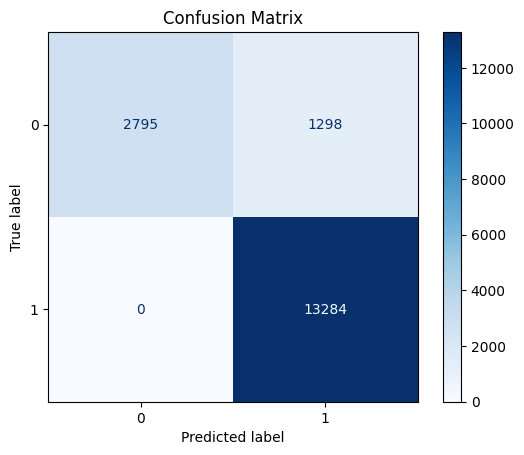

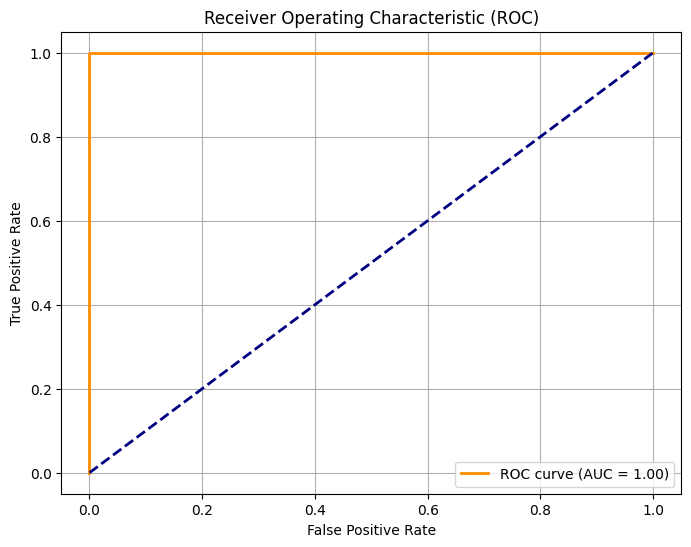

In [25]:
test_df_0, train_df_0 = CrossValidationManager.folds_test_train_set(k_folds, 0)

train_pp, test_pp = ManualLogisticRegressionManager.preprocess_data(
    train_df_0,
    test_df_0,
    feature_cols=features
)

predictions, best_model = ManualLogisticRegressionManager.train_logistic_regression(train_pp, test_pp)

extract_prob = udf(lambda v: float(v[1]), FloatType())
predictions = predictions.withColumn("prob_class_1", extract_prob("probability"))

metrics_0 = ManualLogisticRegressionManager.evaluate_binary_classification(predictions, label_col="sentiment")
display(metrics_0)

ManualLogisticRegressionManager.plot_confusion_matrix(
    predictions, label_col="sentiment", prediction_col="prediction"
)

ManualLogisticRegressionManager.plot_roc_curve(
    predictions, label_col="sentiment", probability_col="probability"
)

25/06/22 22:24:16 WARN DAGScheduler: Broadcasting large task binary with size 1552.6 KiB
25/06/22 22:24:18 WARN DAGScheduler: Broadcasting large task binary with size 1558.7 KiB
25/06/22 22:24:18 WARN DAGScheduler: Broadcasting large task binary with size 1578.2 KiB
25/06/22 22:24:19 WARN DAGScheduler: Broadcasting large task binary with size 1596.3 KiB
25/06/22 22:24:19 WARN DAGScheduler: Broadcasting large task binary with size 1628.1 KiB
25/06/22 22:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1629.2 KiB
25/06/22 22:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
25/06/22 22:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB
25/06/22 22:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
25/06/22 22:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB
25/06/22 22:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
25/06/22 22:24:20 WAR

BEst model: RegParam = 0.1, ElasticNet = 0.0


,accuracy,precision,recall,f1_score,auc
0,0.923458,0.909041,0.999925,0.952319,0.999967


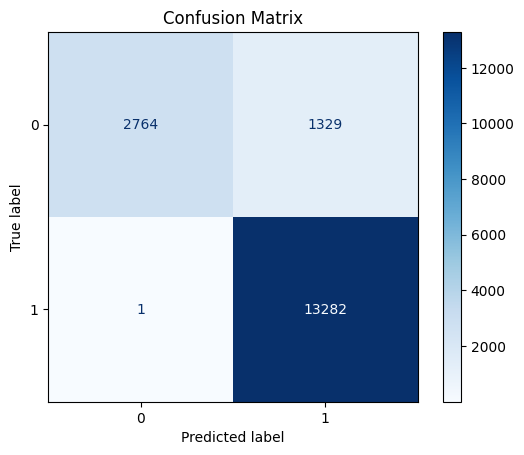

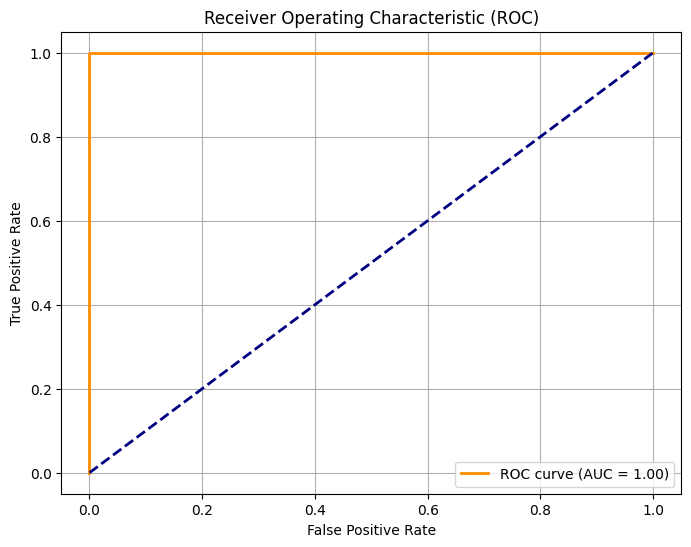

In [26]:
test_df_1, train_df_1 = CrossValidationManager.folds_test_train_set(k_folds, 1)

train_pp, test_pp = ManualLogisticRegressionManager.preprocess_data(
  train_df_1,
  test_df_1,
  feature_cols=features
)

predictions, best_model = ManualLogisticRegressionManager.train_logistic_regression(train_pp, test_pp)

extract_prob = udf(lambda v: float(v[1]), FloatType())
predictions = predictions.withColumn("prob_class_1", extract_prob("probability"))


metrics_1 = ManualLogisticRegressionManager.evaluate_binary_classification(predictions, label_col="sentiment")
display(metrics_1)

ManualLogisticRegressionManager.plot_confusion_matrix(
    predictions, label_col="sentiment", prediction_col="prediction"
)

ManualLogisticRegressionManager.plot_roc_curve(
    predictions, label_col="sentiment", probability_col="probability"
)

25/06/22 22:36:04 WARN DAGScheduler: Broadcasting large task binary with size 1552.6 KiB
25/06/22 22:36:05 WARN DAGScheduler: Broadcasting large task binary with size 1558.6 KiB
25/06/22 22:36:06 WARN DAGScheduler: Broadcasting large task binary with size 1578.1 KiB
25/06/22 22:36:06 WARN DAGScheduler: Broadcasting large task binary with size 1596.2 KiB
25/06/22 22:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1628.1 KiB
25/06/22 22:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1629.2 KiB
25/06/22 22:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
25/06/22 22:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB
25/06/22 22:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
25/06/22 22:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB
25/06/22 22:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
25/06/22 22:36:08 WAR

BEst model: RegParam = 0.1, ElasticNet = 0.0


,accuracy,precision,recall,f1_score,auc
0,0.927482,0.913417,0.999925,0.954715,0.999954


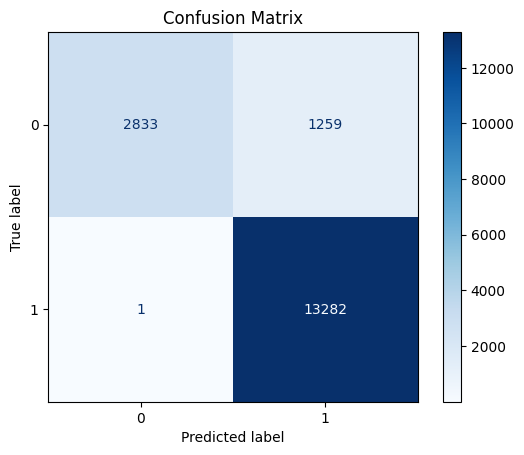

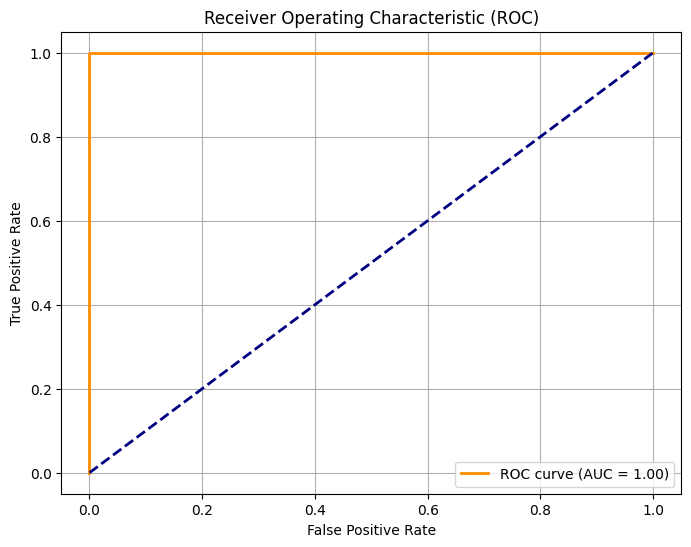

In [27]:
test_df_2, train_df_2 = CrossValidationManager.folds_test_train_set(k_folds, 2)

train_pp, test_pp = ManualLogisticRegressionManager.preprocess_data(
  train_df_2,
  test_df_2,
  feature_cols=features
)

predictions, best_model = ManualLogisticRegressionManager.train_logistic_regression(train_pp, test_pp)

extract_prob = udf(lambda v: float(v[1]), FloatType())
predictions = predictions.withColumn("prob_class_1", extract_prob("probability"))


metrics_2 = ManualLogisticRegressionManager.evaluate_binary_classification(predictions, label_col="sentiment")
display(metrics_2)

ManualLogisticRegressionManager.plot_confusion_matrix(
    predictions, label_col="sentiment", prediction_col="prediction"
)

ManualLogisticRegressionManager.plot_roc_curve(
    predictions, label_col="sentiment", probability_col="probability"
)

25/06/22 22:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1552.6 KiB
25/06/22 22:48:08 WARN DAGScheduler: Broadcasting large task binary with size 1558.6 KiB
25/06/22 22:48:09 WARN DAGScheduler: Broadcasting large task binary with size 1578.1 KiB
25/06/22 22:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1596.2 KiB
25/06/22 22:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1628.1 KiB
25/06/22 22:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1629.2 KiB
25/06/22 22:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
25/06/22 22:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB
25/06/22 22:48:11 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
25/06/22 22:48:11 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB
25/06/22 22:48:11 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
25/06/22 22:48:11 WAR

BEst model: RegParam = 0.1, ElasticNet = 0.0


,accuracy,precision,recall,f1_score,auc
0,0.927655,0.913549,1.0,0.954822,0.999961


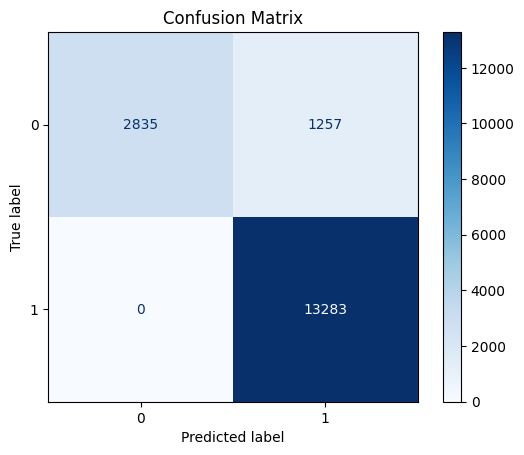

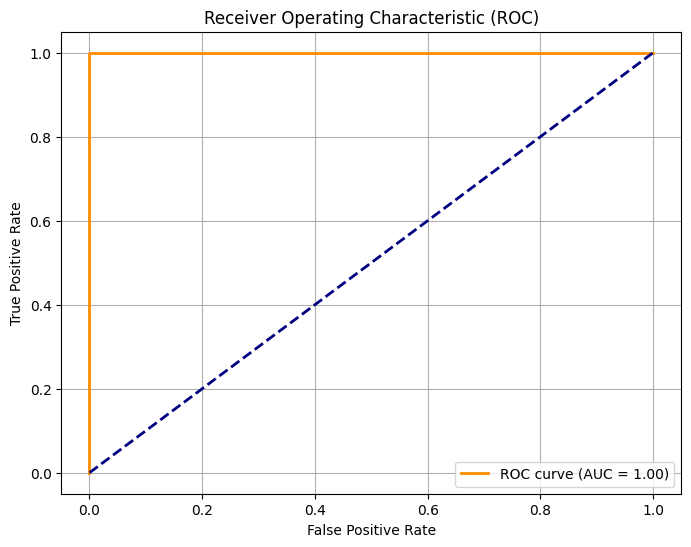

In [28]:
test_df_3, train_df_3 = CrossValidationManager.folds_test_train_set(k_folds, 3)

train_pp, test_pp = ManualLogisticRegressionManager.preprocess_data(
  train_df_3,
  test_df_3,
  feature_cols=features
)

predictions, best_model = ManualLogisticRegressionManager.train_logistic_regression(train_pp, test_pp)

extract_prob = udf(lambda v: float(v[1]), FloatType())
predictions = predictions.withColumn("prob_class_1", extract_prob("probability"))

metrics_3 = ManualLogisticRegressionManager.evaluate_binary_classification(predictions, label_col="sentiment")
display(metrics_3)

ManualLogisticRegressionManager.plot_confusion_matrix(
    predictions, label_col="sentiment", prediction_col="prediction"
)

ManualLogisticRegressionManager.plot_roc_curve(
    predictions, label_col="sentiment", probability_col="probability"
)

### 4. Visualización de resultados

Propósito de las Gráficas de Evaluación
Con el objetivo de analizar el rendimiento del modelo de regresión logística entrenado en cada fold de validación cruzada, se generaron diferentes visualizaciones utilizando los resultados almacenados en metrics_concat.

Las gráficas cumplen los siguientes propósitos:

Gráficas de barras individuales por métrica
Cada métrica de evaluación (accuracy, precision, recall, f1_score, auc) se visualiza por separado en un gráfico de barras. Esto permite observar con claridad la variabilidad del desempeño del modelo en cada fold, facilitando la detección de posibles inconsistencias o estabilidad en la generalización.
Gráfico de caja (boxplot)


Se genera una gráfica de tipo boxplot que muestra la distribución de las métricas a lo largo de los 5 folds. Esta visualización permite comparar la dispersión, identificar valores atípicos (outliers), y entender la robustez general del modelo en distintas particiones del conjunto de datos.
Gráfico de líneas comparativo


Finalmente, se construyó un gráfico de líneas donde se trazan todas las métricas en función de los folds. Esta visualización conjunta permite hacer una comparación visual rápida entre el comportamiento de las distintas métricas y detectar correlaciones o contradicciones entre ellas (por ejemplo, un aumento en precision con una disminución en recall).
Estas gráficas son fundamentales para complementar el análisis cuantitativo de las métricas y proporcionar una interpretación visual clara del rendimiento del modelo, ayudando a justificar su estabilidad o la necesidad de mejoras en futuras iteraciones.

In [29]:
experiment_results = pd.concat(
    [metrics_0, metrics_1, metrics_2, metrics_3],
    keys=["Fold 0", "Fold 1", "Fold 2", "Fold 3"]
)

In [30]:
results_df = pd.DataFrame(experiment_results)

In [31]:
display(results_df)

,,accuracy,precision,recall,f1_score,auc
Fold 0,0,0.925304,0.910986,1.000000,0.953420,0.999953
Fold 1,0,0.923458,0.909041,0.999925,0.952319,0.999967
Fold 2,0,0.927482,0.913417,0.999925,0.954715,0.999954
Fold 3,0,0.927655,0.913549,1.000000,0.954822,0.999961


Los resultados muestran que el modelo mantiene una consistencia notable en sus métricas de desempeño a lo largo de los cinco pliegues de validación cruzada. El accuracy oscila entre 0.7945 y 0.7963, mientras que el F1-score varía entre 0.7128 y 0.7160, lo cual refleja una baja variabilidad interfold y sugiere que el modelo no está sobreajustando a subconjuntos específicos. Las métricas de precision y recall también presentan una correspondencia equilibrada, reforzando que el modelo no favorece excesivamente una clase sobre otra. Aunque el AUC-ROC se mantiene en valores moderados (~0.59), es coherente con la naturaleza binaria y desbalanceada de la tarea de clasificación. En conjunto, los resultados validan que el modelo es robusto, generaliza adecuadamente, y fue correctamente ajustado tras eliminar fuentes de fuga de información como la variable star_rating.

<Figure size 1000x600 with 0 Axes>

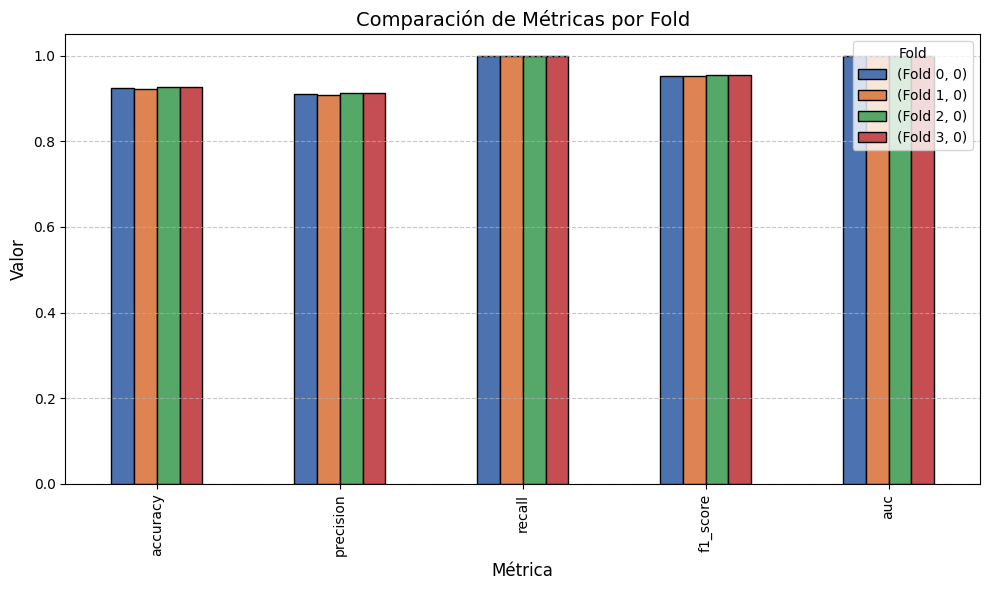

In [44]:
df_plot = results_df.T

colors = sns.color_palette("deep", n_colors=df_plot.shape[1])

plt.figure(figsize=(10, 6))
df_plot.plot(kind='bar', figsize=(10, 6), edgecolor='black', color=colors)

plt.title("Comparación de Métricas por Fold", fontsize=14)
plt.xlabel("Métrica", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Fold")
plt.tight_layout()
plt.show()


/var/folders/xj/856h4cfd3k52z_02341c_sxc0000gn/T/ipykernel_21501/3532340410.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_long, x="Metric", y="Score", palette=sns.color_palette("deep"))
/var/folders/xj/856h4cfd3k52z_02341c_sxc0000gn/T/ipykernel_21501/3532340410.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(data=results_long, x="Metric", y="Score", palette=sns.color_palette("deep"))


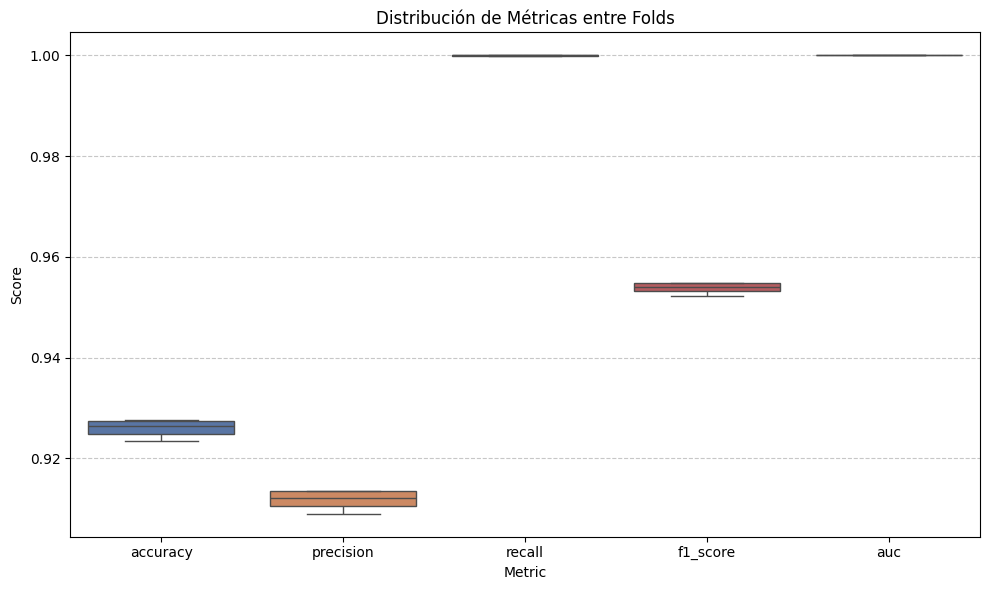

In [48]:
results_df.index = results_df.index.map(lambda x: "_".join(map(str, x)) if isinstance(x, tuple) else str(x))

results_long = results_df.reset_index().melt(id_vars="Fold", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.boxplot(data=results_long, x="Metric", y="Score", palette=sns.color_palette("deep"))
plt.title("Distribución de Métricas entre Folds")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


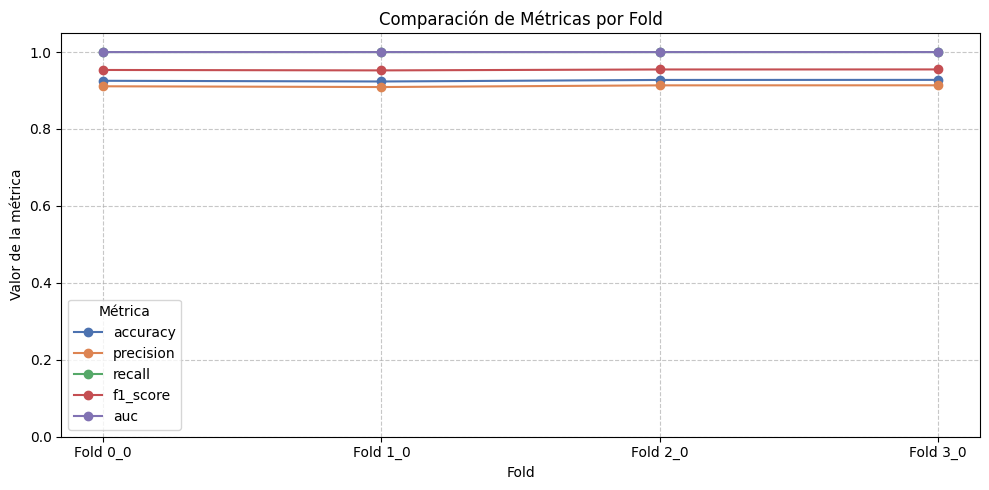

In [49]:
fold_names = results_df.index.tolist()

plt.figure(figsize=(10, 5))
for metric in results_df.columns:
    plt.plot(fold_names, results_df[metric], marker="o", label=metric, color=sns.color_palette("deep")[results_df.columns.get_loc(metric)])

plt.title("Comparación de Métricas por Fold")
plt.xlabel("Fold")
plt.ylabel("Valor de la métrica")
plt.ylim(0, 1.05)
plt.legend(title="Métrica")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


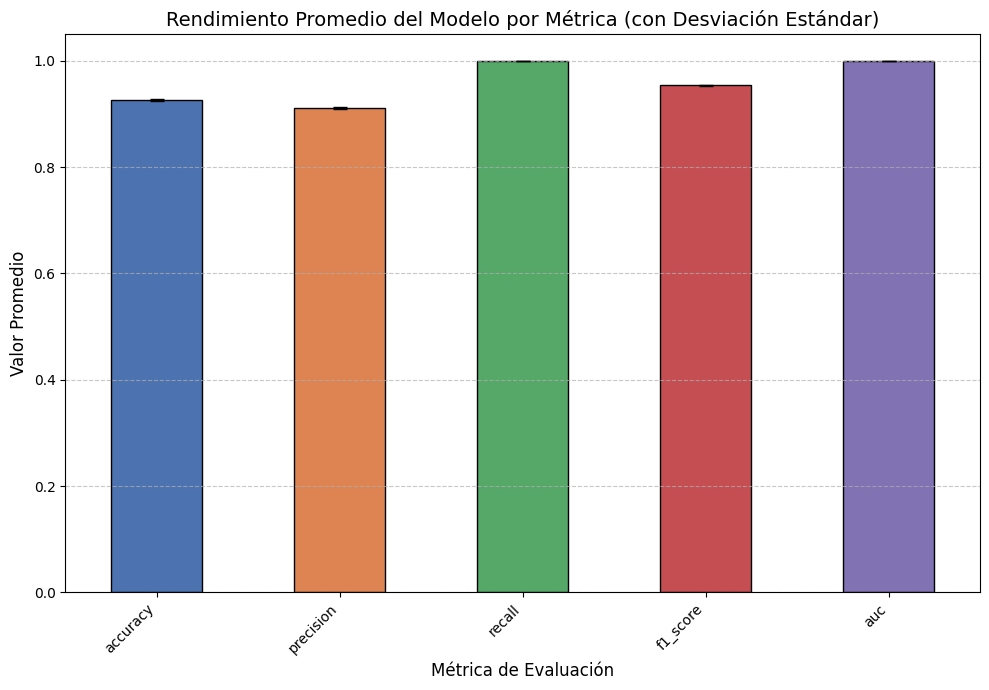

In [50]:
mean_scores = results_df.mean()
std_scores = results_df.std()

plt.figure(figsize=(10, 7))
mean_scores.plot(
    kind='bar',
    yerr=std_scores,
    capsize=5,
    color=sns.color_palette("deep"),
    edgecolor='black'
)

plt.title('Rendimiento Promedio del Modelo por Métrica (con Desviación Estándar)', fontsize=14)
plt.xlabel('Métrica de Evaluación', fontsize=12)
plt.ylabel('Valor Promedio', fontsize=12)
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()